In [ ]:
%load_ext tensorboard
import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers

import tensorflow_datasets as tfds

from tensorflow.data import AUTOTUNE

from utils import display_dataset, predict_tf

In [ ]:
INPUT_SHAPE = (256, 512, 3)
NUM_CLASSES = 2
SCALE = 8

In [3]:
from model import bisenetv2_compiled, bisenetv2_output_shape

OUTPUT_SHAPE = bisenetv2_output_shape(NUM_CLASSES, SCALE, input_shape=INPUT_SHAPE)
m = bisenetv2_compiled(num_classes=NUM_CLASSES, out_scale=SCALE, input_shape=INPUT_SHAPE)

In [4]:
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [5]:
#tf.keras.utils.plot_model(m, show_shapes=True)

In [6]:
cityscapes = tfds.load('cityscapes/semantic_segmentation')

In [7]:
from data_prep import cityscapes_prep, class_map_road
from utils import segmentation_to_image

train_ds = cityscapes['train'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))
valid_ds = cityscapes['validation'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))

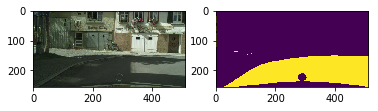

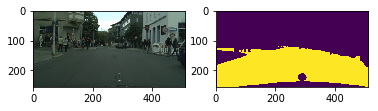

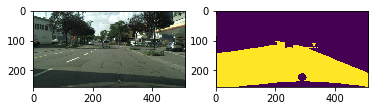

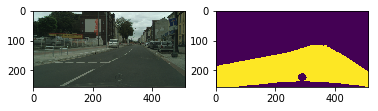

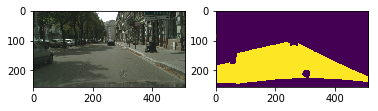

In [8]:
display_dataset(train_ds.take(5), lambda s: (s[0], s[1]))

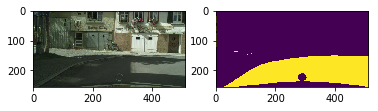

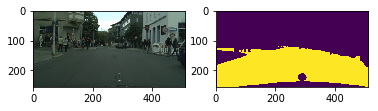

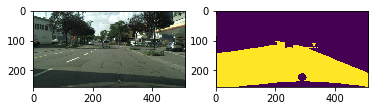

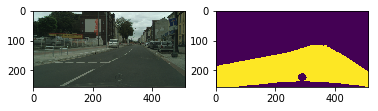

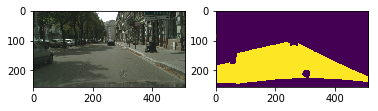

In [9]:
BATCH_SIZE = 16

USE_TINYCAR_DATA = True
USE_AUGMENTATION = True

rng = tf.random.Generator.from_seed(123, alg='philox')

if USE_TINYCAR_DATA:
    from data_prep import labelme_prep, uwula_prep

    ds = tf.data.Dataset.list_files('../paperstreet/1/*.json')
    ds = ds.map(labelme_prep(OUTPUT_SHAPE, INPUT_SHAPE))


    ds2 = tf.data.Dataset.list_files('/media/mldata/tinycar/Mikrowunderland_1k/*.jpg')
    ds2 = ds2.map(uwula_prep(OUTPUT_SHAPE, INPUT_SHAPE))

    ds = ds.concatenate(ds2)
    
    tc_valid_ds = ds.take(24)
    tc_train_ds = ds.skip(24)
    
    train_ds = train_ds.concatenate(tc_train_ds)
    valid_ds = train_ds.concatenate(tc_valid_ds)

if USE_AUGMENTATION:
    def augment(img, seg, seed):
        #seed = tf.random.uniform((2,))
        img = tf.image.stateless_random_brightness(img, 0.2, seed=seed)
        img = tf.image.stateless_random_contrast(img, 0.8, 1.2, seed=seed)
        img = tf.image.stateless_random_saturation(img, 0.0, 1.5, seed=seed)
        img = tf.image.stateless_random_hue(img, 0.2, seed=seed)
        img = tf.clip_by_value(img, 0.0, 1.0) # clip values outside 0..1

        return img, seg

    def randomize(img, seg):
        seed = rng.make_seeds(2)[0]
        img, seg = augment(img, seg, seed)
        return img, seg

    train_ds_flipped_lr = train_ds.map(lambda img, seg: (tf.image.flip_left_right(img), tf.image.flip_left_right(seg)))
    valid_ds_flipped_lr = valid_ds.map(lambda img, seg: (tf.image.flip_left_right(img), tf.image.flip_left_right(seg)))
    
    train_ds_randomized = train_ds.map(randomize)
    valid_ds_randomized = valid_ds.map(randomize)
    
    train_ds_randomized_flipped = train_ds_flipped_lr.map(randomize)
    valid_ds_randomized_flipped = valid_ds_flipped_lr.map(randomize)
    
    train_ds = train_ds.concatenate(train_ds_flipped_lr).concatenate(train_ds_randomized).concatenate(train_ds_randomized_flipped)
    valid_ds = valid_ds.concatenate(valid_ds_flipped_lr).concatenate(valid_ds_randomized).concatenate(valid_ds_randomized_flipped)


train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


display_dataset(valid_ds.unbatch().take(5), lambda s: (s[0], s[1]))

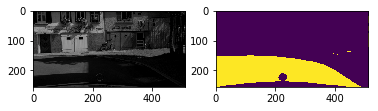

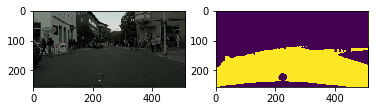

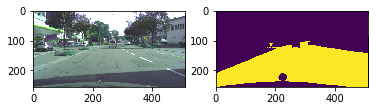

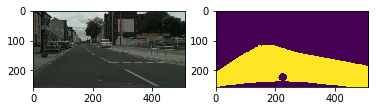

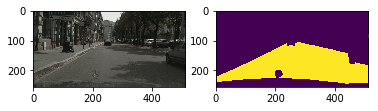

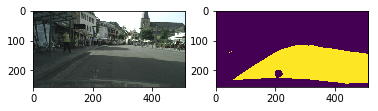

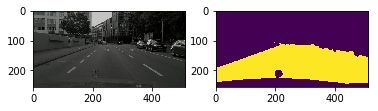

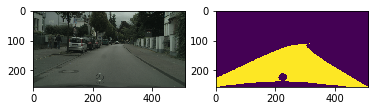

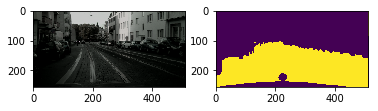

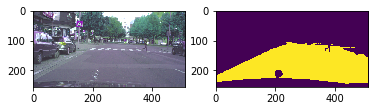

In [10]:
display_dataset(train_ds_randomized_flipped.take(10), lambda s: (s[0], s[1]))

In [ ]:
EPOCHS = 10

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = m.fit(train_ds,
                validation_data=valid_ds,
                epochs=EPOCHS,
                callbacks=[tensorboard_callback])

Epoch 1/10
 158/1014 [===>..........................] - ETA: 19:13 - loss: 0.3230 - accuracy: 0.8547 - argmax_mean_iou: 0.7282

In [12]:
m.save('model8.tf')
#m.save('model_untrained.tf')

INFO:tensorflow:Assets written to: model7.tf/assets


INFO:tensorflow:Assets written to: model7.tf/assets


In [13]:
test_ds = cityscapes['test'].map(cityscapes_prep(OUTPUT_SHAPE, INPUT_SHAPE, class_map_road))

/home/markus/Documents/venv/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


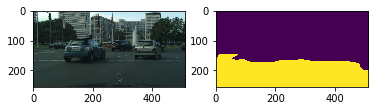

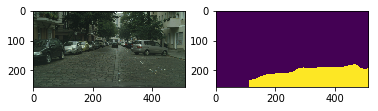

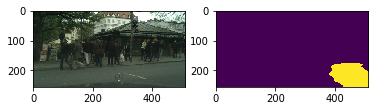

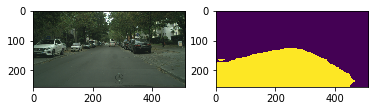

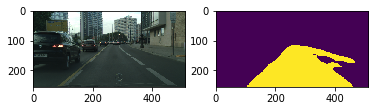

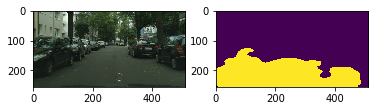

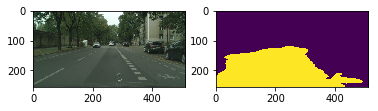

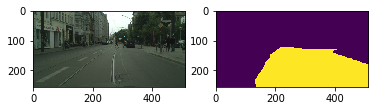

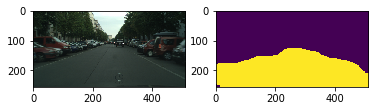

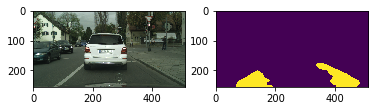

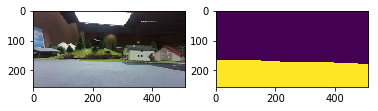

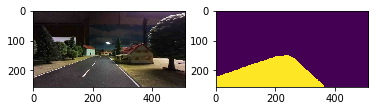

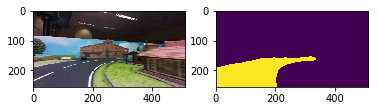

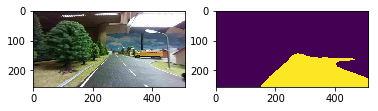

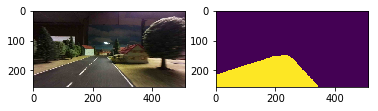

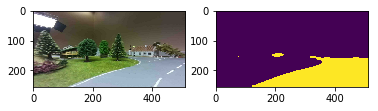

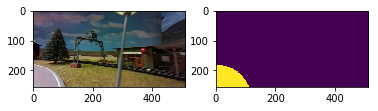

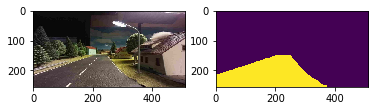

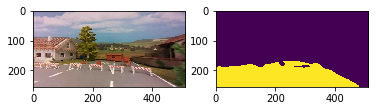

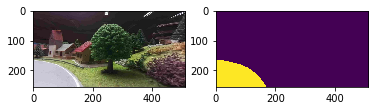

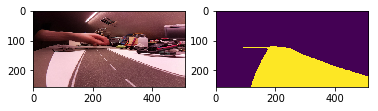

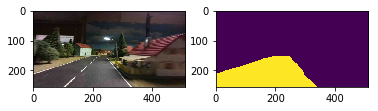

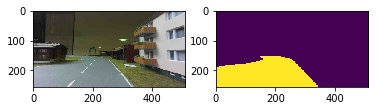

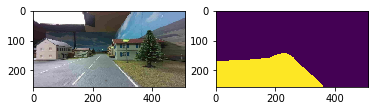

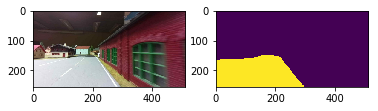

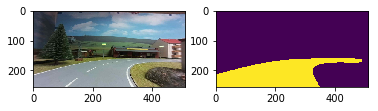

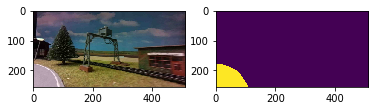

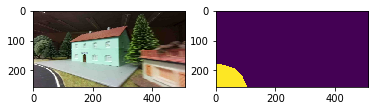

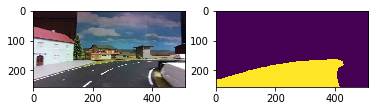

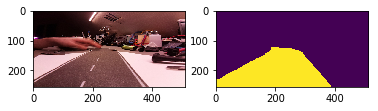

In [14]:
display_dataset(test_ds.take(10), predict_tf(m))
display_dataset(valid_ds.unbatch().take(20), predict_tf(m))